In [1]:
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
from tensorflow import keras
import numpy as np
from numpy.random import rand, randint
import matplotlib.pyplot as plt
import os
import fnmatch
import pandas as pd
import bezier

from matplotlib.backends.backend_agg import FigureCanvasAgg
from matplotlib.figure import Figure

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, Conv2D, Conv3D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


In [1815]:
plt.figure(figsize=(9, 9))
image_width = image_height = 600

image_root = './images/multi_lines/train/'
image_labels = ['line']

total_files = fnmatch.filter(os.listdir(image_root), '*.png')
#print(total_files)

df=pd.read_csv('./images/multi_lines/train.csv', sep=',',header=0)

def image_read(fn):
    link = os.path.join(image_root, fn)
    image = Image.open(link).convert('RGB')
    im = np.asarray(image)
    #print(im.shape)
    return im
    
def generate_bezier(x, y):
    nr = np.asarray(x, y)
    curve = bezier.Curve(nr, degree=1)
    
    return curve

def gen_plots():
    for i in range(9):
        rand_idx = randint(0, len(total_files))
        image, class_id, x, y = getInfo(rand_idx)
        ax = plt.subplot(3, 3, i+1)
        
        l1 = ax.imshow(image, extent=[0, image_height, 0, image_width])
        l1.set_label("")
        
        # Create bezier curve or plot a line
        '''
        curve = generate_bezier(x, y)
        g_truth = curve.plot(num_pts=256, color="r", ax=ax)
        g_truth.lines[-1].set_label('prediction var 1')
        g_truth.lines[-1].set_linestyle('dotted')
        g_truth.lines[-1].set_marker('+')
        g_truth.lines[-1].set_markersize(2)
        '''
        
        ax.plot(x, y, 'r+', linestyle='dotted', label='prediction')
        
        lines, labels = ax.get_legend_handles_labels()
        plt.legend( lines, labels, loc = 'best', bbox_to_anchor = (0,-0.1,1,1),
                    bbox_transform = plt.gcf().transFigure )
        
        plt.xlabel(image_labels[0])
        plt.xticks([])
        plt.yticks([])

#gen_plots()


def getInfo(fn):
    #print(fn)
    image = image_read(fn+".png")
    
    rows = np.where(df.filename==fn)
    
    class_id = df["class"][rows[0][0]]
    coords = []
    
    for i in rows[0]:
        c_id = []
        c_coord = []
        
        c_coord.append(df.xmin[i])
        c_coord.append(df.xmax[i])
        c_coord.append(df.ymin[i])
        c_coord.append(df.ymax[i])
        
        coords.append(c_coord)
        c_id = []
    
    return image, class_id, coords

<Figure size 648x648 with 0 Axes>

# PLOT LINE

In [1793]:
def tester():
    rand_idx = randint(0, len(total_files))
    image, class_id, x, y = getInfo(rand_idx)
    return image

def plot_line(image, pred_coords, norm=False):
    figo = Figure(figsize=(2, 2))

    canvas = FigureCanvasAgg(figo)

    # plot
    ax_r = figo.add_subplot()
    if norm:
        image *= 255.
        image = image.astype(np.uint8)
    ax_r.imshow(image, extent=[0,image_height,0,image_width])
    
    for i in pred_coords:
        xmin, xmax, ymin, ymax = i
        ax_r.plot([xmin, xmax], [ymin, ymax], 'r+', linestyle='dotted', label='prediction')
    
    '''
    if len(pred_coords) == 2:
        x, y = pred_coords
        #print(x, y)
        xmin = x[0]
        xmax = x[1]
        ymin = y[0]
        ymax = y[1]
        ax_r.plot([xmin, xmax], [ymin, ymax], 'r+', linestyle='dotted', label='prediction')
    '''
    ax_r.set_axis_off()

    canvas.draw()

    buf = canvas.buffer_rgba()
    # ... convert to a NumPy array ...
    X = np.asarray(buf)
    # ... and pass it to PIL.
    im = Image.fromarray(X)

    return im

def randlGen():
    rElem = np.random.choice(total_files)
    rElem = rElem[0:-4]
    return rElem

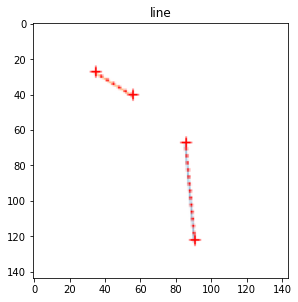

In [1797]:
#rand_idx = randint(0, len(total_files))

image, class_id, pred_coords = getInfo(randlGen())

image = plot_line(image, pred_coords)
plt.imshow(np.flipud(image))
plt.title("line")
plt.tight_layout(pad=0)
plt.show()

# Ground truth pixels with testing (DISBANDED!)

In [1812]:


def gtDistance1(index, test):
    
    threshold = 0.01
    image, class_id, p1, p2 = getInfo(index)

    gTruth = np.zeros((h,w,1))
    
    p1 = np.asarray([x / image_height for x in p1])
    p2 = np.asarray([x / image_width for x in p2])
    
    #print(p1)
    
    for i,j in enumerate(image):
        for k,l in enumerate(image):
            x1 = i/h 
            x2 = k/w
            p3 = np.asarray([x1,x2])
            
            dis = np.abs(np.cross(p2-p1, p1-p3)) / np.linalg.norm(p2-p1)
            #print(dis)
            if(test != True):
                if (dis <= threshold):
                    gTruth[i][k] = 1
                else:
                    gTruth[i][k] = 0
            else:
                if (dis <= threshold):
                    gTruth[i][k] = 0
                else:
                    gTruth[i][k] = 255
    #print(gTruth)
    return gTruth


def gtNaive(index):
    image, class_id, x, y = getInfo(index)
    # Naive non-generalized method
    
    gTruth = np.zeros((h,w,1))
    #x[0][0] = [2]
    
    for i,j in enumerate(image):
        for k,l in enumerate(image):
            if (np.all(image[i][k] == 255)):
                gTruth[i][k] = 0
            else:
                gTruth[i][k] = 255
    return [image,gTruth]

#gtNaive(1)

#test_sbs(311, gtDistance2)

'''
x, y = gtNaive(103)

plt.subplot(1, 2, 1)
plt.imshow(x)
plt.subplot(1, 2, 2)
plt.imshow(y)
'''
'''
def linear(coord):
    
    n_a = []
    
    for i in coord:
        OldValue = i
        OldMax = 143
        OldMin = 0
        NewMax = 17
        NewMin = 0
        OldRange = (OldMax - OldMin)  
        NewRange = (NewMax - NewMin)  
        x = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
        n_a.append(x)
    
    return np.asarray(n_a)
'''
def gtDistance2(index, test):
    
    threshold = 1
    image_orig, class_id, p1, p2 = getInfo(index)
    image = image_orig.reshape((1,image_height,image_width,3))
    
    gTruth = np.zeros((18,18,1))
    
    y = tf.image.extract_patches(images=image,
                           sizes=[1, 8, 8, 1],
                           strides=[1, 8, 8, 1],
                           rates=[1, 1, 1, 1],
                           padding='SAME')
    
    p1 = linear(p1)
    p2 = linear(p2)
    #print(p1, p2)
          
    for x in y[0]:
        for i,j in enumerate(x):
            for k,l in enumerate(x):
                #print(i,k)
                
                p3 = np.asarray([i,k])
                #print(p1, p2, p3)

                dis = np.abs(np.cross(p2-p1, p1-p3)) / np.linalg.norm(p2-p1)
                #print(dis)
                
                if(test != True):
                    if (dis <= threshold):
                        gTruth[i][k] = 1
                    else:
                        gTruth[i][k] = 0
                else:
                    if (dis <= threshold):
                        gTruth[i][k] = 0
                    else:
                        gTruth[i][k] = 255
    #print(gTruth.shape)
    #plt.imshow(gTruth)
    return gTruth
    
    
#gtDistance2(178, False)



'''
def test_sbs(index, method):
    image, class_id, x, y = getInfo(index)
    pimg = method(index, False)
    
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.subplot(1, 2, 2)
    plt.imshow(pimg)
    
    plt.subplot(121)
    plt.plot(image)
    plt.subplot(121)
    plt.plot(pimg)
'''  
#test_sbs(133, gtDistance2)
    

'\ndef test_sbs(index, method):\n    image, class_id, x, y = getInfo(index)\n    pimg = method(index, False)\n    \n    plt.subplot(1, 2, 1)\n    plt.imshow(image)\n    plt.subplot(1, 2, 2)\n    plt.imshow(pimg)\n    \n    plt.subplot(121)\n    plt.plot(image)\n    plt.subplot(121)\n    plt.plot(pimg)\n'

# Pixel gTruth and Line gTruth

In [1825]:
def linear(coord):
    n_a = []
    
    for i in coord:
        OldValue = i
        OldMax = image_width-1
        OldMin = 0
        NewMax = 17
        NewMin = 0
        OldRange = (OldMax - OldMin)  
        NewRange = (NewMax - NewMin)  
        x = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
        n_a.append(x)
    
    return np.asarray(n_a)

def midPoint(p12):
    x1, x2, y1, y2 = p12
    
    x = (x1 + x2)/2
    y = (y1 + y2)/2
    
    return x,y

def gtruther(index):

    image, class_id, coords = getInfo(index)
    
    #truther shapes
    pxTruth = np.zeros((18,18,1))
    liTruth = np.zeros((18,18,4))
    
    if (class_id == 1):
        for i in coords:
            x1, x2, y1, y2 = i
            
            #p12 = i
            #mapping
            #print("old coords: ", i)
            p12 = linear(i)
            #print("new coords: ", p12)

            #find mp
            mp = midPoint(p12)
            mp = np.around(mp)
            #print(mp)
            #mp coords
            x, y = mp.astype(int)

            #line coords
            x1, x2, y1, y2 = p12

            #allot line gt coords of mp coords to liTruth shape
            liTruth[x][y] = i
            pxTruth[y][x] = [class_id]
            

    return image, liTruth, pxTruth
    
#gtruther("li_200")

def test_sbs(index):
    image, class_id, coords = getInfo(index)
    pimg = gtruther(index)
    
    plt.subplot(1, 2, 1)
    #plt.tight_layout(pad=0)
    plt.imshow(np.flipud(image))
    plt.subplot(1, 2, 2)
    plt.imshow(pimg)
    
#test_sbs("li_401")

# DATA GEN

In [1800]:
# check line 13 later - random???"

batch_size = len(total_files)
def data_generator(batch_size=batch_size):
    while True:
        x_batch = np.zeros((batch_size, image_height, image_width, 3))
        y_batch = np.zeros((batch_size, 18, 18, 1))
        bline_batch = np.zeros((batch_size, 18, 18, 4))
        #print(bline_batch)
        
        for i,j in enumerate(total_files[0:batch_size]):
            #j = j[0:-4]
            
            image, liTruth, pxTruth = gtruther(randlGen())
            
            x_batch[i] = image / 255.
            y_batch[i] = pxTruth
            bline_batch[i] = liTruth

            #print(({'image': x_batch}, {'class_out': y_batch, 'line_out': bline_batch}))
            
        yield ({'image': x_batch}, {'class_out': y_batch, 'line_out': bline_batch})

In [1801]:
def extractor(class_id, pred_coords):
    
    #for label
    count = 0
    pos = []
    coords = []
    
    #gT label
    for i,j in enumerate(class_id):
        for k,l in enumerate(class_id):
            if(class_id[i][k] == 1):
                pos.append([i,k])
                count = count + 1
    
    for i,j in enumerate(pred_coords):
        for k,l in enumerate(pred_coords):
            if (all(i != 0 for i in pred_coords[i][k])):
                coords.append(pred_coords[i][k])
    
    #print(count, coords)
    return count, coords
    

In [1802]:
def testerxo():
    index = 94
    example, label = next(data_generator(100))
    print(example)
    image = example['image'][index]
    class_id = label['class_out'][index]
    pred_coords = label['line_out'][index]

    count, coords = extractor(class_id, pred_coords)

    image = plot_line(image, coords, norm=True)

    plt.imshow(image)
    plt.title('line')
    plt.show()

    '''
    x = [pred_coords[0], pred_coords[1]]
    y = [pred_coords[2], pred_coords[3]]

    image = plot_line(image, pred_coords=[x, y], norm=True)

    plt.imshow(image)
    plt.title('line')
    plt.show()
    '''
#testerxo()

# MODEL

In [1784]:
'''
def model2():
    
    backbone             = keras.applications.MobileNet(include_top=False, pooling='avg')
    classification_layer = keras.layers.Dense(1, activation='softmax', name='class_out')
    regression_layer     = keras.layers.Dense(4, name='box_out')

    x = x0   = keras.Input(shape=(None,None,3), name='image')
    x        = backbone(x)
    x1        = classification_layer(x)
    x2        = regression_layer(x)
    model    = keras.Model(inputs=x0, outputs=[x1, x2])
    
    return model
'''

In [1579]:

model = model2()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
mobilenet_1.00_224 (Functional) (None, 1024)         3228864     image[0][0]                      
__________________________________________________________________________________________________
class_out (Dense)               (None, 1)            1025        mobilenet_1.00_224[0][0]         
__________________________________________________________________________________________________
box_out (Dense)                 (None, 4)            4100        mobilenet_1.00_224[0][0]         
Total params: 3,233,989
Trainable params: 3,212,101
Non-trainable params: 21,888
___________

In [1785]:
def modelTester():
    input_ = Input(shape=(image_height, image_width, 3), name='image')

    x = input_

    for i in range(0, ):
      n_filters = 2**(4 + i)
      x = Conv2D(n_filters, 1, activation='relu')(x)
      x = BatchNormalization()(x)
      x = MaxPool2D(2)(x)
    '''
    x1 = Conv2D(1, (3,3), name="class_out")(x)
    x2 = Conv2D(4, (3,3), name="line_out")(x)
    '''
    model = tf.keras.models.Model(input_, [x])
    model.summary()
    
#modelTester()

Model: "model_123"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 600, 600, 3)]     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [1803]:
def model1():
    h = w = 600
    
    backbone             = keras.applications.MobileNet(input_shape=(h,w,3), include_top=False)
    
    x = x0   = keras.Input(shape=(h,w,3), name='image')
    x        = backbone(x)
    
    x1 = Conv2D(1, (1,1), name="class_out")(x)
    x2 = Conv2D(4, (1,1), name="line_out")(x)
    #x = Conv2D(2048, (7, 7), strides = (1, 1))(x)
    model    = keras.Model(inputs=x0, outputs=[x1,x2])
    
    return model

model = model1()
model.summary()

Model: "model_125"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
mobilenet_1.00_224 (Functional) (None, 18, 18, 1024) 3228864     image[0][0]                      
__________________________________________________________________________________________________
class_out (Conv2D)              (None, 18, 18, 1)    1025        mobilenet_1.00_224[0][0]         
__________________________________________________________________________________________________
line_out (Conv2D)               (None, 18, 18, 4)    4100        mobilenet_1.00_224[0][0]         
Total params: 3,233,989
Trainable params: 3,212,101
Non-trainable params: 21,888
_________

In [1804]:
#_metrics = ['tf.keras.metrics.RootMeanSquaredError()', '']
model.compile(
    loss={
        'class_out': 'binary_crossentropy',
        'line_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'line_out': [tf.keras.metrics.MeanAbsoluteError()]
    }
)

In [1816]:
def plot_line2(image, pred_coords, norm=False):
    figo = Figure(figsize=(2, 2))

    canvas = FigureCanvasAgg(figo)

    # plot
    ax_r = figo.add_subplot()
    if norm:
        image *= 255.
        image = image.astype(np.uint8)
    ax_r.imshow(image, extent=[0,image_height,0,image_width])
    
    for i in pred_coords:
        xmin, xmax, ymin, ymax = i
        ax_r.plot([xmin, xmax], [ymin, ymax], 'r+', linestyle='dotted', label='prediction')
    
    ax_r.set_axis_off()

    canvas.draw()

    buf = canvas.buffer_rgba()
    # ... convert to a NumPy array ...
    X = np.asarray(buf)
    # ... and pass it to PIL.
    im = Image.fromarray(X)

    return im

In [1817]:
def test_model(model, test_datagen):
    
    example, label = next(test_datagen)
    
    image = example['image']
    class_id = label['class_out']
    
    #gtruth lines
    coords = label['line_out']
    gtcount, gtcoords = extractor(class_id[0], coords[0])
    
    #predicted lines
    pred_class, pred_line = model.predict(image)
    pred_count, pred_coords = extractor(pred_class[0], pred_line[0])

    #class_id
    gt = 0 if gtcount == 0 else 1
    pred_class_name = 0 if pred_count == 0 else 1
    
    image = plot_line2(image[0], pred_coords, norm=True)

    color = 'green' if gt == pred_class_name else 'red'
    
    plt.imshow(np.flipud(image))
    
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    '''
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['line_out'][0]   

    pred_y, pred_box = model.predict(x)

    pred_coords = pred_box[0]
    xc = [pred_coords[0], pred_coords[1]]
    yc = [pred_coords[2], pred_coords[3]]

    #print(xc, yc)

    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = "line"
    pred_class_name = "line"

    box = [[box[0], box[1]], [box[2], box[3]]]

    image = plot_line(image, pred_coords=[xc, yc], norm=True)
    color = 'green' if gt == pred_class_name else 'red'

    plt.imshow(image)
    #plt.show()
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])
    '''

In [1818]:
def test(model):
    test_datagen = data_generator(1)
    
    plt.figure(figsize=(16, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.show()
  

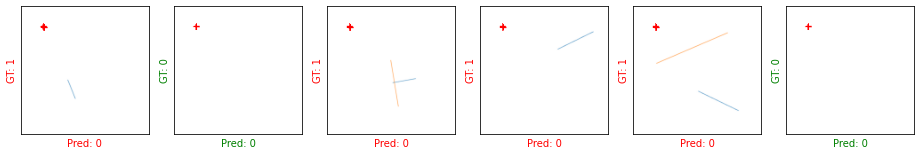

In [1822]:
test(model)

In [1556]:
class ShowTestImages(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test(self.model)

# Model Training

In [1826]:
def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2
  return max(lr, 3e-7)


_ = model.fit(
    data_generator(batch_size=100),
    use_multiprocessing=True,
    workers=5,
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
               ShowTestImages(),
               tf.keras.callbacks.EarlyStopping(monitor='line_out', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[100,64,300,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_125/mobilenet_1.00_224/conv_pw_1/Conv2D (defined at <ipython-input-1823-1a16278d3c0f>:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_4515310]

Function call stack:
train_function
